<a href="https://colab.research.google.com/github/MarkStephens060482/Classification/blob/main/Deep_Learning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Neural Network Classification
##Fashion MNIST data set
### Mark Stephens

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow
!pip install scikeras

# 1. Load and inspect the data

We will use the Fashion MNIST dataset (built into Keras/TF), which are all small images of different clothing items. They can be found in `keras.datasets.fashion_mnist`

1. Load the dataset and display the size of the various parts

In [ ]:
from tensorflow import keras
from keras import datasets
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()
print(f'The instances of training data is {X_train.shape[0]} images with {X_train.shape[1]} x {X_train.shape[2]} pixels')
print(f'The instances of testing data is {X_test.shape[0]} images with {X_test.shape[1]} x {X_test.shape[2]} pixels')

The instances of training data is 60000 images with 28 x 28 pixels
The instances of testing data is 10000 images with 28 x 28 pixels


2. Display, graphically, one example image of each class

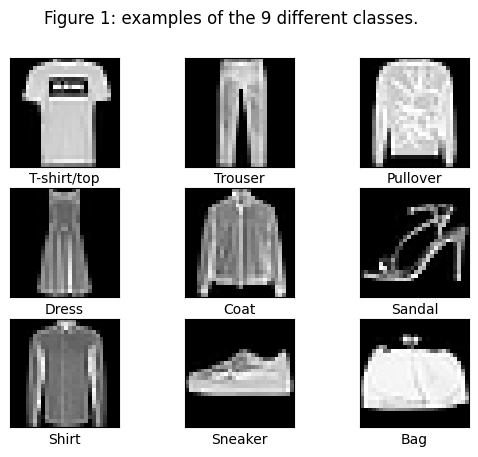

In [ ]:
import matplotlib.pyplot as plt
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# define subplot
fig,axs = plt.subplots(3,3)
axs = axs.ravel()
j = 0
#loop through each subplot
for i,ax in enumerate(axs):
  # loop through class labels and plot 1 of each type of class
  while i != y_train[j]:
    j+=1
  class_name = class_names[y_train[j]]
  # plot raw pixel data
  ax.set_xticks([])
  ax.set_yticks([])
  ax.grid(False)
  ax.imshow(X_train[j], cmap=plt.get_cmap('gray'))
  ax.set_xlabel(class_name)
# show the figure
fig.suptitle('Figure 1: examples of the 9 different classes.')
plt.show()

Figure 1 gives instances of 9 different classes from the data set.

3. Display summary stats/info for class labels

In [ ]:
import pandas as pd 
import numpy as np

# Summary Statistics for class labels
pd.DataFrame(np.hstack((y_train,y_test))).describe()

,0
count,70000.000000
mean,4.500000
std,2.872302
min,0.000000
25%,2.000000
50%,4.500000
75%,7.000000
max,9.000000


In [ ]:
# counts for class labels
pd.DataFrame(np.hstack((y_train,y_test))).value_counts()

0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
dtype: int64

4. Split the non-test labels and images into training and validation datasets according to a 80/20 split

In [ ]:
#use scikit learn 
from sklearn.model_selection import train_test_split
X_train,X_validate,y_train,y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=41)

5. Do appropriate pre-processing of the images and/or labels

In [ ]:
# min max normalisation as preprocessing of data
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

#use a function to transform the data by reshaping it from 28 x 28 to 784
def reshape(X):
  '''
  reshape the data to (n_samples, 
  '''
  return X.reshape(X.shape[0],X.shape[1]*X.shape[2])

#define a transformer step    
transformer = FunctionTransformer(reshape)

# define a preprocessing pipeline
preproc = make_pipeline(transformer,MinMaxScaler())

# train the preprocessor on the training data
preprocessor = preproc.fit(X_train)

# transform the validation set using the preprocessor
X_validate_processed = preprocessor.transform(X_validate)

# 2. Build a network

Write a *function* that creates a Keras model of a densely connected neural network and returns it, in a state where it is ready to have `fit()` run on it.
 - The API should take in:
     1. values for the number of neurons in hidden layers 1, 2 and 3 (as a list or array - where the length of the list/array indicates fewer hidden layers)
     2. a string for the loss function
     3. the learning rate
 - In addition:
     4. set the optimizer to be Adam
     5. set the activation functions in the hidden layers to be ReLU
     6. include the additional metric of 'accuracy'


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.optimizers import Adam
from keras.backend import clear_session
from scikeras.wrappers import KerasClassifier

# Function to create model, required for KerasClassifier
def model_build_fn(layers: list[int],activation: list[str],lrate: float,loss_func: str):
  """
  defines the artificial neural network model with keras.
  layers: The number of neurons in the hidden layers defined as list.
  activation: The activation function of neurons in the hidden layers defined as a list.
  lrate: learning rate for optimiser.
  loss_func: The loss function used in compiling the modelling.
  """
  #kera starts with a blank state
  clear_session()
  # develop a sequential model.
  model = Sequential()
  # flatten the input images as the product of the pixels.
  model.add(Input(shape = (28*28,)))
  # Create model using a loop of the layers list.
  for i,layer in enumerate(layers):
     model.add(Dense(layer,activation = activation[i]))
  #set the last layer as the output layer with 10 nodes, one for each class.
  model.add(Dense(10,activation = 'softmax'))
  #initialise optimiser with learning rate
  opt = Adam(learning_rate = lrate)
  # Compile model
  model.compile(loss = loss_func, optimizer = opt, metrics = ['accuracy'])
  #print summary of the model
  return model

# Sklearn wrapper of the keras model
sklearn_model = KerasClassifier(model = model_build_fn,
                                layers = [128,64],
                                activation = ['relu','relu'],
                                lrate = 0.001,
                                loss_func ='sparse_categorical_crossentropy')
# model pipeline
estimator1 = make_pipeline(preproc,sklearn_model)

# 3. Train the network

1. Call the function written in the previous section to generate a model with the following arguments: 2 hidden layers only, first with 128 nodes and the second with 64 nodes; loss function of categorical cross-entropy (you should determine which type is suitable for your data); and a learning rate of 0.001.

In [ ]:
### Set the parameters of the model
layers = [128,64]
activation = ['relu','relu']
lrate = 0.001
loss_func = 'sparse_categorical_crossentropy'
#define a dictionary of parameters for the keras model
params1 = {'kerasclassifier__layers' : layers,
          'kerasclassifier__activation': activation,
          'kerasclassifier__lrate' : lrate,
          'kerasclassifier__loss_func' : loss_func}
# set the parameters of the model to the defined values.
estimator1.set_params(**params1)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function reshape at 0x7faa6056cee0>)),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('kerasclassifier',
                 KerasClassifier(activation=['relu', 'relu'], layers=[128, 64], loss_func='sparse_categorical_crossentropy', lrate=0.001, model=<function model_build_fn at 0x7faa6056d000>))])

2. Print a summary of the model that is generated.

In [ ]:
# Summary of the Keras model.
model_build_fn(layers,activation,lrate,loss_func).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


3. Train the model using a batch size of 2000 and 5 epochs, saving the training history.

In [ ]:
# training the model with the given number of epoc hand batch size and saving the training history
history1 = estimator1.fit(X_train, 
                        y_train,
                        kerasclassifier__epochs=5,
                        kerasclassifier__batch_size=2000,
                        kerasclassifier__validation_data=(X_validate_processed, y_validate))

Epoch 1/5
24/24 [==============================] - 2s 44ms/step - loss: 1.2658 - accuracy: 0.5671 - val_loss: 0.7437 - val_accuracy: 0.7389
Epoch 2/5
24/24 [==============================] - 1s 43ms/step - loss: 0.6272 - accuracy: 0.7826 - val_loss: 0.5681 - val_accuracy: 0.8050
Epoch 3/5
24/24 [==============================] - 1s 53ms/step - loss: 0.5178 - accuracy: 0.8231 - val_loss: 0.4999 - val_accuracy: 0.8272
Epoch 4/5
24/24 [==============================] - 1s 53ms/step - loss: 0.4698 - accuracy: 0.8397 - val_loss: 0.4593 - val_accuracy: 0.8410
Epoch 5/5
24/24 [==============================] - 2s 90ms/step - loss: 0.4376 - accuracy: 0.8504 - val_loss: 0.4448 - val_accuracy: 0.8462


In [ ]:
#record the history of the training process as a dictionary
history1_record_dict = history1.named_steps['kerasclassifier'].history_

4. Display the learning curves.

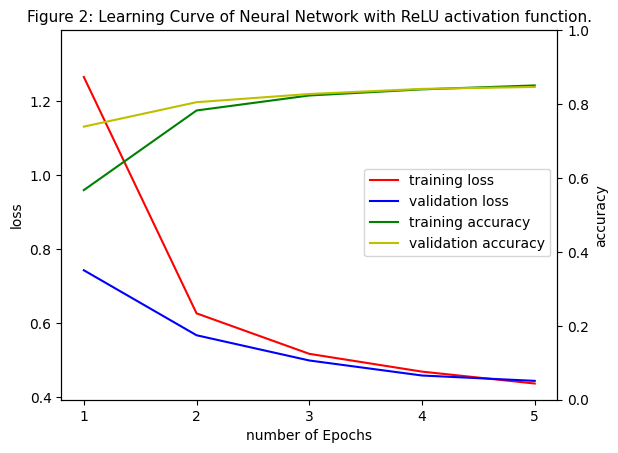

<Axes: title={'center': 'Figure 2: Learning Curve of Neural Network with ReLU activation function.'}, xlabel='number of Epochs', ylabel='loss'>

In [ ]:
from matplotlib.ticker import MaxNLocator
#define a function to produce a learning curve from training history
def learning_curve(training_history_record,title,ax = None):
  """
  Produces a learning curve of training and validation loss and accuracy scores over number of epochs 
  as determined by training and recorded history.
  Argument:
  training_history_record - The recorded training history as a dictionary from calling fit() on the keras model.
  title - The figure title as a string
  """
  if ax is None:
    ax = plt.gca()
  # history is saved in the history_ attribute.
  lc_df = pd.DataFrame(training_history_record).reset_index()
  lc_df['index'] = lc_df['index'] + 1
  #rename the column headings
  lc_df.rename(columns={"index":"number of Epochs",
                        "loss":"training loss",
                        "accuracy":"training accuracy",
                        "val_loss":"validation loss",
                        "val_accuracy":"validation accuracy"},
                        inplace = True)
  # plot the loss values for training and validation on two different y axis
  lc_df.plot(x="number of Epochs",y="training loss",ax = ax,legend = False,color = "r")
  lc_df.plot(x="number of Epochs",y="validation loss",ax = ax,legend = False,color = "b")
  #initialise a second axis
  ax2 = ax.twinx()
  #plot the accuracy for training and validation on two different axis
  lc_df.plot(x="number of Epochs",y="training accuracy",ax = ax2,legend = False, color = "g")
  lc_df.plot(x="number of Epochs",y="validation accuracy",ax = ax2,legend = False, color = "y")
  #position the legend
  ax.figure.legend(loc=7,bbox_to_anchor=(0.9, 0.5))
  #label the axis
  ax.set_ylabel("loss")
  #set the range on the axis
  ax.set_ylim(lc_df["training loss"].min()*0.9,lc_df["training loss"].max()*1.1)
  ax2.set_ylabel("accuracy")
  ax2.set_ylim(0,1)
  # Hide grid lines
  ax.grid(False)
  ax.set_title(title,size = 11)
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  #produces the graph
  plt.show() 
  return(ax)

ax = plt.subplot()
# produce the learning curve graph
title = "Figure 2: Learning Curve of Neural Network with ReLU activation function."
learning_curve(history1_record_dict,title,ax)

5. Answer the following questions on fitting (give reasons in each case):
 - Does this show overfitting?
 - Does this show underfitting?
 - Has the model converged?
 - Is it stable or unstable?

The learning curve in figure 2 demonstrates a good fit and is converging. The learning curve does not exhibit signs of overfitting as training and validation scores for both loss and accuracy are very similar. However, the learning curve graph may resemble a slightly underfitted model as the trends in the curve suggest that the accuracy metric may increase further. Also, the graph shows little change over the epochs, suggesting slow to converge, and may benefit from adjusting the learning rate. Overall, the training and validation losses are similar and have decreased close to a minimum by the 4th and 5th epoch, showing little change. The model appears stable as the values of accuracy smoothly increase as loss smoothly decrease over epochs.

# 4. Network architecture comparison

Build and train two alternative networks.

1.1. Build and train a network using a sigmoid activation function in the hidden layers, plotting the learning curves.
   

In [ ]:
#build a dense neural network with sigmoid activation
# model pipeline
estimator2 = make_pipeline(preproc,sklearn_model)
### Set the parameters of the model
layers = [128,64]
activation = ['sigmoid','sigmoid']
lrate = 0.001
loss_func = 'sparse_categorical_crossentropy'

#define a dictionary of parameters for the keras model
params2 = {'kerasclassifier__layers' : layers,
          'kerasclassifier__activation': activation,
          'kerasclassifier__lrate' : lrate,
          'kerasclassifier__loss_func' : loss_func}

# set the parameters of the model to the defined values.
estimator2.set_params(**params2)
# Summary of the Keras model.
model_build_fn(layers,activation,lrate,loss_func).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training the model with the given number of epoc hand batch size and saving the training history
history2 = estimator2.fit(X_train, 
                        y_train,
                        kerasclassifier__epochs=5,
                        kerasclassifier__batch_size=2000,
                        kerasclassifier__validation_data=(X_validate_processed, y_validate))

Epoch 1/5
24/24 [==============================] - 3s 81ms/step - loss: 2.0493 - accuracy: 0.4348 - val_loss: 1.7391 - val_accuracy: 0.5484
Epoch 2/5
24/24 [==============================] - 1s 62ms/step - loss: 1.5133 - accuracy: 0.6063 - val_loss: 1.3064 - val_accuracy: 0.6513
Epoch 3/5
24/24 [==============================] - 2s 72ms/step - loss: 1.1652 - accuracy: 0.6931 - val_loss: 1.0403 - val_accuracy: 0.7172
Epoch 4/5
24/24 [==============================] - 1s 57ms/step - loss: 0.9510 - accuracy: 0.7331 - val_loss: 0.8752 - val_accuracy: 0.7456
Epoch 5/5
24/24 [==============================] - 2s 92ms/step - loss: 0.8152 - accuracy: 0.7545 - val_loss: 0.7665 - val_accuracy: 0.7577


In [ ]:
#record the history of the training process as a dictionary
history2_record_dict = history2.named_steps['kerasclassifier'].history_

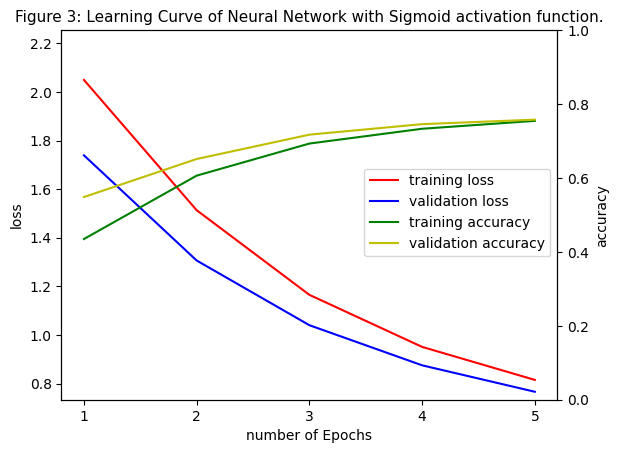

<Axes: title={'center': 'Figure 3: Learning Curve of Neural Network with Sigmoid activation function.'}, xlabel='number of Epochs', ylabel='loss'>

In [ ]:
# initialise the axis
ax = plt.subplot()
# produce the learning curve graph
title = "Figure 3: Learning Curve of Neural Network with Sigmoid activation function."
learning_curve(history2_record_dict,title,ax)

Figure 3 shows the achieved accuracy by the DNN with sigmoid activastion after 5 epochs is markedly less than that for ReLU activation. 

1.2. Build and train a network using a LeakyReLU activation function in the hidden layers, plotting the learning curves. 

In [ ]:
from keras.layers import LeakyReLU
from keras.initializers import HeNormal
#build a neural network with LeakyRelu activation
# Function to create model, required for KerasClassifier

def LeakyReLUmodel_build_fn(layers: list[int],alpha: float,lrate: float):
  """
  defines the dense neural network model using Leaky ReLU activation function with keras.
  Arguments:
  layers = The number of neurons in the hidden layers defined as list.
  alpha = The parameter for the Leaky ReLU activation function gives gradient for linear component when x<0.
  lrate = learning rate for optimiser.
  """ 
  #kera starts with a blank state
  clear_session()
  # develop a sequential model.
  model = Sequential()
  # Create model sequentially
  # flatten the input images as the product of the pixels.
  model.add(Input(shape = (28*28,)))
  # add the first hidden layer
  model.add(Dense(layers[0],kernel_initializer=HeNormal(seed = 1)))
  # now add a ReLU activation explicitly
  model.add(LeakyReLU(alpha=alpha))
  # add the second hidden layer
  model.add(Dense(layers[1],kernel_initializer=HeNormal(seed = 1)))
  # now add a ReLU activation explicitly
  model.add(LeakyReLU(alpha=alpha))
  #set the last layer as the output layer with 10 nodes, one for each class.
  model.add(Dense(10,activation = 'softmax'))
  #initialise optimiser with learning rate
  opt = Adam(learning_rate = lrate)
  # Compile model
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
  return model

# Sklearn wrapper of the keras model
sklearn_model3 = KerasClassifier(model = LeakyReLUmodel_build_fn,
                                 layers = [128,64],
                                 alpha = 0.01,
                                 lrate = 0.001)
# model pipeline
estimator3 = make_pipeline(preproc,sklearn_model3)
### Set the parameters of the model
layers = [128,64]
alpha = 0.01
lrate = 0.001
#define a dictionary of parameters for the keras model
params3 = {'kerasclassifier__layers' : layers,
          'kerasclassifier__alpha': alpha,
          'kerasclassifier__lrate' : lrate}

# set the parameters of the model to the defined values.
estimator3.set_params(**params3)
# Summary of the Keras model.
LeakyReLUmodel_build_fn(layers,alpha,lrate).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


The hyperparameter $\alpha$ of the Leaky ReLU activation function is to be tuned to find the best value.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

alpha_range = uniform(0,0.03)
randomsearch = RandomizedSearchCV(estimator = estimator3,
                                  param_distributions={'kerasclassifier__alpha' : alpha_range},
                                  cv = 3,
                                  n_iter = 60,
                                  n_jobs=-1)

randomsearch_result = randomsearch.fit(X_train,
                                       y_train,
                                       kerasclassifier__verbose = 0,
                                       kerasclassifier__epochs = 5,
                                       kerasclassifier__batch_size=2000,
                                       kerasclassifier__validation_data=(X_validate_processed, y_validate))
print(f"The best value for the Leaky ReLU alpha is: {randomsearch_result.best_params_['kerasclassifier__alpha']}")
best_alpha = randomsearch_result.best_params_['kerasclassifier__alpha']
#define a dictionary of parameters for the keras model
params3 = {'kerasclassifier__layers' : layers,
          'kerasclassifier__alpha': best_alpha,
          'kerasclassifier__lrate' : lrate}

# set the parameters of the model to the defined values.
estimator3.set_params(**params3)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The best value for the Leaky ReLU alpha is: 0.012480760342354335


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('functiontransformer',
                                  FunctionTransformer(func=<function reshape at 0x7faa6056cee0>)),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('kerasclassifier',
                 KerasClassifier(alpha=0.012480760342354335, layers=[128, 64], lrate=0.001, model=<function LeakyReLUmodel_build_fn at 0x7faa5e167250>))])

In [ ]:
# training the model with the given number of epoc hand batch size and saving the training history
history3 = estimator3.fit(X_train, 
                          y_train,
                          kerasclassifier__epochs=5,
                          kerasclassifier__batch_size=2000,
                          kerasclassifier__validation_data=(X_validate_processed, y_validate))

Epoch 1/5
24/24 [==============================] - 1s 44ms/step - loss: 1.1849 - accuracy: 0.6091 - val_loss: 0.7064 - val_accuracy: 0.7452
Epoch 2/5
24/24 [==============================] - 1s 32ms/step - loss: 0.6050 - accuracy: 0.7893 - val_loss: 0.5449 - val_accuracy: 0.8087
Epoch 3/5
24/24 [==============================] - 1s 43ms/step - loss: 0.5100 - accuracy: 0.8231 - val_loss: 0.5078 - val_accuracy: 0.8142
Epoch 4/5
24/24 [==============================] - 1s 54ms/step - loss: 0.4708 - accuracy: 0.8351 - val_loss: 0.4576 - val_accuracy: 0.8378
Epoch 5/5
24/24 [==============================] - 1s 53ms/step - loss: 0.4379 - accuracy: 0.8481 - val_loss: 0.4409 - val_accuracy: 0.8454


In [ ]:
#record the history of the training process as a dictionary
history3_record_dict = history3.named_steps['kerasclassifier'].history_

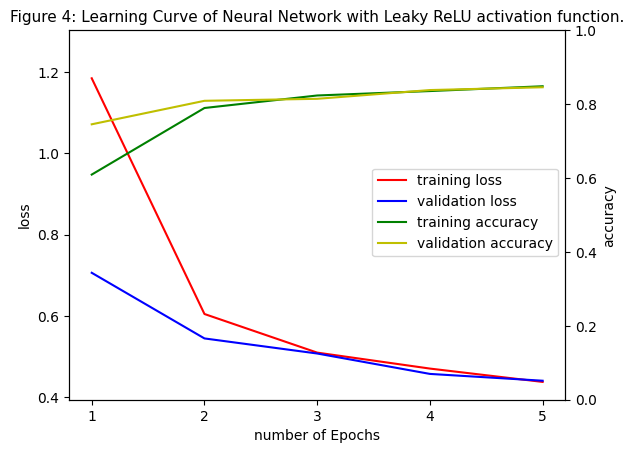

<Axes: title={'center': 'Figure 4: Learning Curve of Neural Network with Leaky ReLU activation function.'}, xlabel='number of Epochs', ylabel='loss'>

In [ ]:
# initialise the axis
ax = plt.subplot()
# produce the learning curve graph
title = "Figure 4: Learning Curve of Neural Network with Leaky ReLU activation function."
learning_curve(history3_record_dict,title,ax)

2. Compare the performance appropriately to select the best activation function from these two and ReLU above (state your reasons).


Text(0.5, 0.98, 'Figure 5: DNN model performance after 5 epochs.')

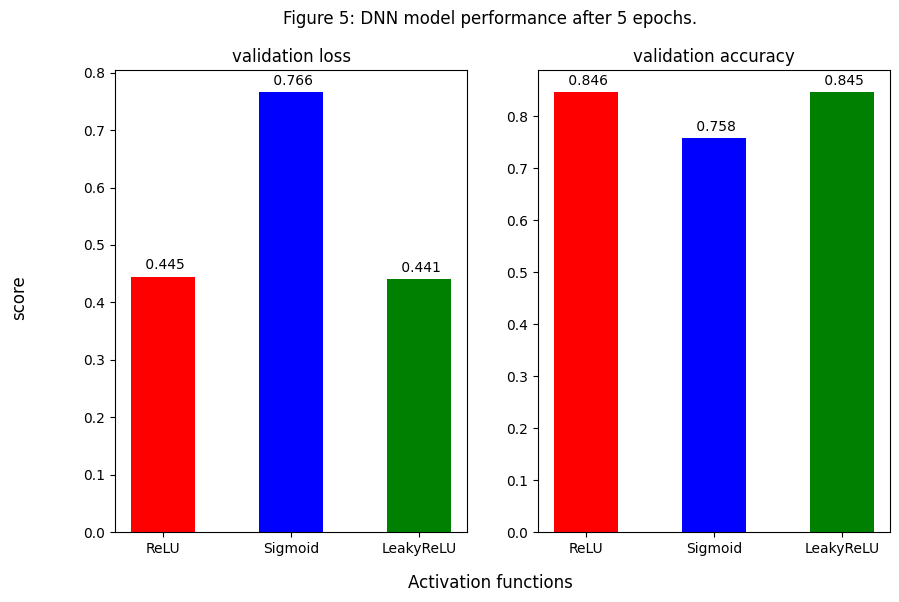

In [ ]:
epoch = 5
results_dict = {}
# Loop through the model training history dictionaries and grab validation scores
for metric in ['val_loss','val_accuracy']:
  scores = []
  for history_record_dict in [history1_record_dict,history2_record_dict,history3_record_dict]:
    scores.append(history_record_dict[metric][epoch-1])  
  #collate the validation scores for all three activation functions in a results dictionary   
  results_dict[metric] = scores
# represent as a dataframe
results_df = pd.DataFrame(results_dict,index = ['ReLU','Sigmoid','LeakyReLU'] )
results_df.rename(columns={"val_loss":"validation loss","val_accuracy":"validation accuracy"},inplace = True)
#intitialise a subplot
fig,axs = plt.subplots(1,2,figsize=(10, 6))
#loop through the two validation score metrics and plot a bar graph 
axs = axs.ravel()
for i,col in enumerate(results_df.columns):
  bars = axs[i].bar(results_df.index, results_df[col],width = 0.5,color = ['r','b','g'] )
  axs[i].set_title(f"{col}")
#annotate bars with values
# Loop through the bars and add annotations
  for bar in bars:
    height = bar.get_height()
    axs[i].annotate(f'{height: 0.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
    textcoords="offset points", ha='center', va='bottom')
# include figure and axis labels
fig.supxlabel('Activation functions')
fig.supylabel('score')
fig.suptitle(f"Figure 5: DNN model performance after {epoch} epochs.")

Figure 5 gives a comparison of validation scores, as they are an estimate of the generalisatrion error. For this particular training run, the Leaky ReLU activation function gives the smaller loss value, however the ReLU activation function gives the larger accuracy measure. However, the validation score values are quite similar between ReLU and Leaky ReLU and training on only 5 epochs may not have allowed the model to properly converge. The DNN with ReLU activation gives better validation scores than that for sigmoid, but comparable to a DNN with Leaky ReLU activation. Further examination in comparing performance of the DNN with ReLU activation against Leaky ReLU activation may give greater insight.  

 3. Repeat the model building and training for 4.1.1 and 4.1.2 above and compare the new results with the previous ones. How different are the results?  And how important is this difference?

In [ ]:
#Repeating the model building for the sigmoid activation function.
# model pipeline
estimator2_repeated = make_pipeline(preproc,sklearn_model)
### Set the parameters of the model
layers = [128,64]
activation = ['sigmoid','sigmoid']
lrate = 0.001
loss_func = 'sparse_categorical_crossentropy'

#define a dictionary of parameters for the keras model
params2_repeat = {'kerasclassifier__layers' : layers,
                  'kerasclassifier__activation': activation,
                  'kerasclassifier__lrate' : lrate,
                  'kerasclassifier__loss_func' : loss_func}

# set the parameters of the model to the defined values.
estimator2_repeated.set_params(**params2_repeat)

# Repeat the training of the model with the given number of epochs and batch size and saving the training history
history2_repeated = estimator2_repeated.fit(X_train, 
                                        y_train,
                                        kerasclassifier__epochs=5,
                                        kerasclassifier__batch_size=2000,
                                        kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                        kerasclassifier__verbose = 0)
#record the history of the repeated training process as a dictionary
history2_repeated_record_dict = history2_repeated.named_steps['kerasclassifier'].history_

#Repeating the model building for the Leaky ReLU activation function.
# Sklearn wrapper of the keras model
sklearn_model3_repeated = KerasClassifier(model = LeakyReLUmodel_build_fn,
                                          layers = layers,
                                          alpha = best_alpha,
                                          lrate = lrate)                          
# model pipeline
estimator3_repeated = make_pipeline(preproc,sklearn_model3_repeated)
#define a dictionary of parameters for the keras model
params3_repeat = {'kerasclassifier__layers' : layers,
                  'kerasclassifier__alpha': best_alpha,
                  'kerasclassifier__lrate' : lrate}
# set the parameters of the model to the defined values.
estimator3_repeated.set_params(**params3_repeat)
# training the model with the given number of epoc hand batch size and saving the training history
history3_repeated = estimator3_repeated.fit(X_train, 
                                            y_train,
                                            kerasclassifier__epochs=5,
                                            kerasclassifier__batch_size=2000,
                                            kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                            kerasclassifier__verbose = 0)
#record the history of the training process as a dictionary
history3_repeated_record_dict = history3_repeated.named_steps['kerasclassifier'].history_
new_line = '\n'
print(f"The validation loss and validation accuracy for DNN with sigmoid activation are: {new_line}\
{history2_record_dict['val_loss'][-1]:0.3f} and {history2_record_dict['val_accuracy'][-1]:0.3f} respectively.{new_line}\
When the building and training of the model is repeated, the scores are: {new_line}\
{history2_repeated_record_dict['val_loss'][-1]:0.3f} and {history2_repeated_record_dict['val_accuracy'][-1]:0.3f} respectively.{new_line}")
print(f"The validation loss and validation accuracy for DNN with Leaky ReLU activation are: {new_line}\
{history3_record_dict['val_loss'][-1]:0.3f} and {history3_record_dict['val_accuracy'][-1]:0.3f} respectively.{new_line}\
When the building and training of the model is repeated, the scores are: {new_line}\
{history3_repeated_record_dict['val_loss'][-1]:0.3f} and {history3_repeated_record_dict['val_accuracy'][-1]:0.3f} respectively.{new_line}")

The validation loss and validation accuracy for DNN with sigmoid activation are: 
0.766 and 0.758 respectively.
When the building and training of the model is repeated, the scores are: 
0.765 and 0.756 respectively.

The validation loss and validation accuracy for DNN with Leaky ReLU activation are: 
0.441 and 0.845 respectively.
When the building and training of the model is repeated, the scores are: 
0.445 and 0.840 respectively.



A variation is observed in validation loss and validation accuracy upon repeating the building and training of the DNN for both sigmoid and Leaky ReLU activation. This difference is important when comparing performances of Leaky ReLU against ReLU activation as the scores are quite similar, and for any given repeated training process, the outcome may eventuate in either being regarded as the better performing function.The occurrence of the variation in scores is due to the stochastic nature of the optimiser, ADAptive Moment estimation, or Adam. The value of $α$ for Leaky ReLU can be adjusted appropriately to ensure better performance, where a larger value will tend to give unstable, low performing validation scores. 

To examine whether a significant difference is observed between validation scores of the DNN with ReLU compared to Leaky ReLU, a sample of $n$ repeated trainings is taken for each activation function. This is done for a larger number of epochs than previously when training the DNN to promote convergence. A parallel box plot is given to show the comparison of each metric, and an independent t-test is performed to test the hypothesis that validation scores of ReLU and Leaky ReLU are not statistically different. 

In [ ]:
# size of the sample of validation scores under repeated training.
samples_n = 35
# number of epochs per training of model.
epochs_n = 10
#defining list to keep measures.
LeakyReLU_loss=[]
LeakyReLU_accuracy=[]
ReLU_loss=[]
ReLU_accuracy=[]
#repeated training of DNN models for both ReLU and Leaky ReLU
for i in range(samples_n):
  ###Leaky ReLU
  #Repeating the model building for the Leaky ReLU activation function.
  # Sklearn wrapper of the keras model
  sklearn_model3_repeated_test = KerasClassifier(model = LeakyReLUmodel_build_fn,
                                                 layers = layers,
                                                 alpha = best_alpha,
                                                 lrate = lrate)                          
  # model pipeline
  estimator3_repeated_test = make_pipeline(preproc,sklearn_model3_repeated_test)
  # training the model with the given number of epoc hand batch size and saving the training history
  history3_repeated_test = estimator3_repeated_test.fit(X_train, 
                                                        y_train,
                                                        kerasclassifier__epochs=epochs_n,
                                                        kerasclassifier__batch_size=2000,
                                                        kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                                        kerasclassifier__verbose = 0)
  #record the history of the training process as a dictionary
  history3_repeated_record_test_dict = history3_repeated_test.named_steps['kerasclassifier'].history_
  #append validation scores to list for a sample of size n
  LeakyReLU_loss.append(history3_repeated_record_test_dict['val_loss'][-1])
  LeakyReLU_accuracy.append(history3_repeated_record_test_dict['val_accuracy'][-1])

  ### ReLU
  # Sklearn wrapper of the keras model
  sklearn_model1_repeated_test = KerasClassifier(model = model_build_fn,
                                                layers = [128,64],
                                                activation = ['relu','relu'],
                                                lrate = 0.001,
                                                loss_func ='sparse_categorical_crossentropy')
  # model pipeline
  estimator1_repeated_test = make_pipeline(preproc,sklearn_model1_repeated_test)
  # training the model with the given number of epoc hand batch size and saving the training history
  history1_repeated_test = estimator1_repeated_test.fit(X_train, 
                                                        y_train,
                                                        kerasclassifier__epochs=epochs_n,
                                                        kerasclassifier__batch_size=2000,
                                                        kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                                        kerasclassifier__verbose = 0)
  #record the history of the training process as a dictionary
  history1_repeated_record_test_dict = history1_repeated_test.named_steps['kerasclassifier'].history_
  #append validation scores to list for a sample of size n
  ReLU_loss.append(history1_repeated_record_test_dict['val_loss'][-1])
  ReLU_accuracy.append(history1_repeated_record_test_dict['val_accuracy'][-1]) 

#collect as dataframe
val_scores_test_df = pd.DataFrame(np.c_[LeakyReLU_loss,ReLU_loss,LeakyReLU_accuracy,ReLU_accuracy],
                                  columns = ['loss_LeakyReLU','loss_ReLU','accuracy_LeakyReLU','accuracy_ReLU'])
#id variable
val_scores_test_df['id']=val_scores_test_df.index
val_scores_test_df.head(5)

,loss_LeakyReLU,loss_ReLU,accuracy_LeakyReLU,accuracy_ReLU,id
0,0.377081,0.382965,0.869667,0.867667,0
1,0.373968,0.379954,0.871167,0.865833,1
2,0.377730,0.386237,0.868083,0.865417,2
3,0.382718,0.375157,0.866833,0.868333,3
4,0.379841,0.376803,0.867500,0.868917,4


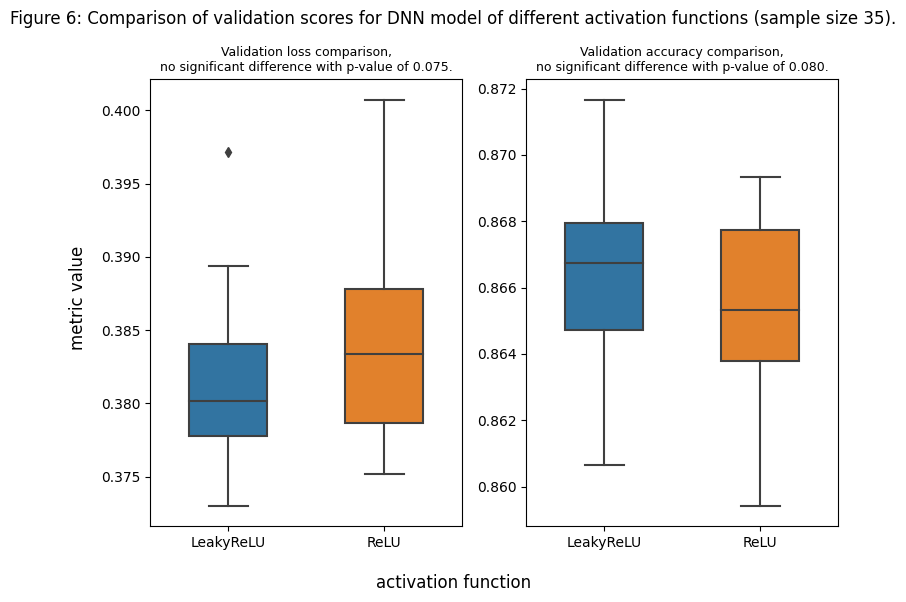

In [ ]:
from scipy.stats import ttest_ind
import seaborn as sns
# Independent t-tests for sample of loss and accuracy metrics
res1 = ttest_ind(np.array(ReLU_loss), np.array(LeakyReLU_loss))
res2 = ttest_ind(np.array(ReLU_accuracy), np.array(LeakyReLU_accuracy))

# define a function that returns results of t-test, t-statistic and p-value.
def ttest(res,thres):
  """
  returns outcome of t-test.
  argument:
  res - results tuple of (t-statitic,p-value)
  thres - alpha, significance level.
  """
  if res[1] < thres:
    return f'significant difference with p-value of {res[1]:0.03f}.'
  return f'no significant difference with p-value of {res[1]:0.03f}.'

#convert to long form of the dataframe
val_scores_test_long_df = pd.melt(pd.wide_to_long(val_scores_test_df,
                                        ['loss','accuracy'],
                                        i ='id',
                                        j='activation',
                                        sep='_',
                                        suffix=r'\w+').reset_index().drop(columns = 'id'),
                                id_vars = ['activation'], 
                                value_vars =['loss','accuracy'],
                                var_name = 'metric')
# produce parallel boxplots of samples of validation scores of DNN with activation functions.
fig,axs = plt.subplots(1,2, figsize = (8,6))
data1 = val_scores_test_long_df.loc[val_scores_test_long_df['metric']=='loss'][['activation','value','metric']]
#produce boxplot for loss metric
sns.boxplot(data = data1,x = 'activation',y='value',ax = axs[0],width = 0.5)
axs[0].set_title(f'Validation loss comparison,{new_line}{ttest(res1,0.05)}',fontsize=9)
axs[0].set_xlabel('')
axs[0].set_ylabel('')
data2 = val_scores_test_long_df.loc[val_scores_test_long_df['metric']=='accuracy'][['activation','value','metric']]
#produce boxplot for accuracy metric
sns.boxplot(data = data2,x = 'activation',y='value',ax = axs[1],width = 0.5)
axs[1].set_title(f'Validation accuracy comparison,{new_line}{ttest(res2,0.05)}',fontsize=9)
axs[1].set_xlabel('')
axs[1].set_ylabel('')
#labels
fig.supxlabel('activation function')
fig.supylabel('metric value')
fig.suptitle(f'Figure 6: Comparison of validation scores for DNN model of different activation functions\
 (sample size {samples_n}).')
plt.tight_layout()

Figure 6 demonstrates that the DNN model with Leaky ReLU activation appears to perform slightly better than with ReLU activation, demonstrating an improvement in the median scores for both validation loss and accuracy. A two sample independent t-test on validation loss and accuracy fails to reject the null hypothesis that the population means of the validation scores are equivalent, and so no statistically significant difference between the values for the two activation functions is observed.

The Leaky ReLU activation function has an advantage over the sigmoid activation function in preventing the vanishing gradient problem, as well as an advantage over the ReLU activation function in preventing the problem of dying nodes. Therefore, Leaky ReLU may be considered the best activation function to be used in this DNN model.

# 5. Hyper-parameter optimisation

1. Implement early-stopping using an appropriate callback, included in the call to fit() - see example in Module 4. 

In [ ]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
from keras.callbacks import EarlyStopping 
early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                  patience=4,
                                  min_delta=0.005,
                                  mode = 'max',
                                  restore_best_weights=True) 

The early stopping callback monitors validation accuracy and will stop training if the score does not change by an interval of 0.003 for 5 epochs in a row. It will then take the value of the previous best score.

2. Run the network with a range of learning rates (0.01, 0.1, 10 and 100 _times_ the base value used above) and compare learning curves to choose the best rate.

In [ ]:
#Early stopping regularisation is used, an arbitaryly large number of epochs may be used for training.
epochs_n = 50
# The estimator to use is defined previously, estimator3
### Set the parameters of the model
layers = [128,64]
base_lrate = 0.001
#having a range of learning rates as multiples of the base value, 0.001
lrate_range =list(map(lambda x: base_lrate*x,[0.01,0.1,10,100]))

training_histories = []
for lrate in lrate_range:
  # Sklearn wrapper of the keras model
  sklearn_model3 = KerasClassifier(model = LeakyReLUmodel_build_fn,
                                   layers = layers,
                                   alpha = best_alpha,
                                   lrate = lrate,
                                   callbacks = early_stopping_cb)# employing early stopping callback, routes param to fit
  # model pipeline
  estimator3 = make_pipeline(preproc,sklearn_model3)

  # training the model with the given number of epoc hand batch size and saving the training history,
  # employing early stopping callback.
  history3_tuning = estimator3.fit(X_train, 
                                  y_train,
                                  kerasclassifier__epochs = epochs_n,
                                  kerasclassifier__batch_size=2000,
                                  kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                  kerasclassifier__verbose = 0)
                                  

  #record the history of the training process as a dictionary
  history3_tuning_record_dict = history3_tuning.named_steps['kerasclassifier'].history_
  #append dictionaries of training history in list
  training_histories.append(history3_tuning_record_dict) 

The training histories are appended to a list. The list is iterated through and the validation accuracy and number of epochs are plotted as line graphs.

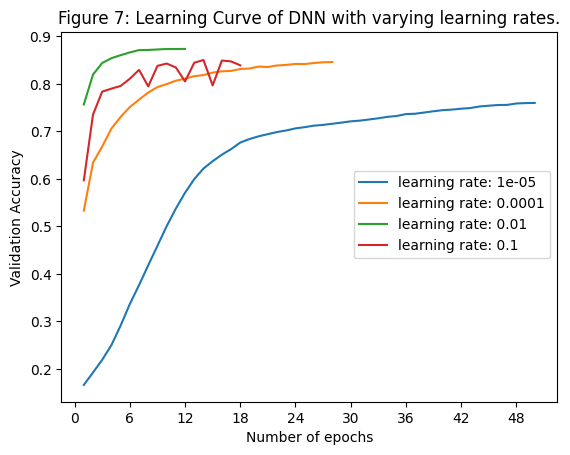

In [ ]:
from matplotlib.pyplot import cm
# initialise the axis
ax = plt.subplot()
for i,train_h in enumerate(training_histories):
  accuracy = np.array(train_h['val_accuracy'])
  loss = np.array(train_h['val_loss'])
  epochs = np.arange(1,len(accuracy)+1)
  # produce the learning curve graph
  ax.plot(epochs,accuracy, label=f"learning rate: {lrate_range[i]}")
#position the legend
ax.figure.legend(loc=7,bbox_to_anchor=(0.9, 0.5))
#label the axis
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Number of epochs")
ax.set_title(f"Figure 7: Learning Curve of DNN with varying learning rates.",size = 12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#produces the graph
plt.show()  

The learning curves in figure 7 suggest that the DNN with a learning rate of 0.01 achieves the best performance, converging in less than 15 epochs. The learning rate of 0.1 leads the DNN to  underperform and is unstable, while learning rates less that 0.01, leads to the DNN underfitting.  

***
3. After having chosen the best learning rate, do a simple parameter sweep for the number of nodes in the first hidden layer (using 16, 32, 64, 128, 256, 512, 1024) and display both individual learning curves as well as a summary plot of the results showing performance vs number of nodes.
     - Note that it you want you can make the output more concise by suppressing text output with the _verbose=0_ option to fit()

In [ ]:
# parameter sweep for the number of nodes in the first  hidden layer
nodes_range = [16,32,64,128,256,512,1024]
best_lrate = 0.01
training_histories = []
for nodes in nodes_range:
  # Sklearn wrapper of the keras model
  sklearn_model3 = KerasClassifier(model = LeakyReLUmodel_build_fn,
                                   layers = [nodes,64], # first hidden layer has variable nodes
                                   alpha = best_alpha,
                                   lrate = best_lrate,
                                   callbacks = early_stopping_cb) # employing early stopping callback, routes params to fit
  # model pipeline
  estimator3 = make_pipeline(preproc,sklearn_model3)
  # training the model with the given number of epoc hand batch size and saving the training history,
  history3_tuning = estimator3.fit(X_train, 
                                  y_train,
                                  kerasclassifier__epochs = epochs_n,
                                  kerasclassifier__batch_size=2000,
                                  kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                  kerasclassifier__verbose = 0)   

  #record the history of the training process as a dictionary
  history3_tuning_record_dict = history3_tuning.named_steps['kerasclassifier'].history_
  #append dictionaries of training history in list
  training_histories.append(history3_tuning_record_dict) 

The model is fitted 7 times, one for each number of nodes in the first hidden layer. The learning curves are given below in figure 8.

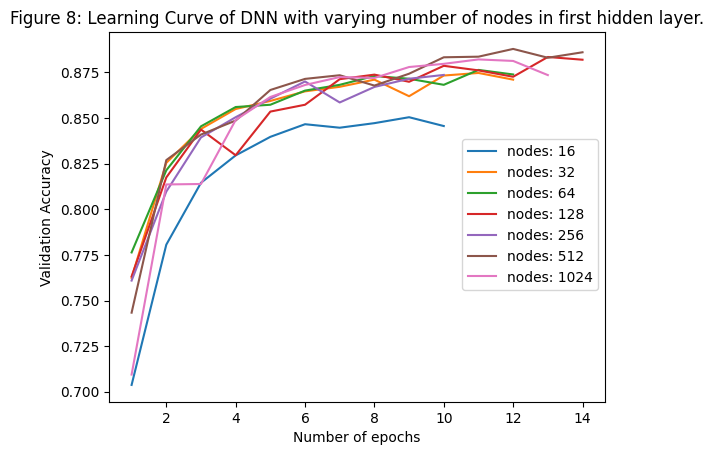

In [ ]:
# initialise the axis
ax = plt.subplot()
for i,train_h in enumerate(training_histories):
  accuracy = np.array(train_h['val_accuracy'])
  epochs = np.arange(1,len(accuracy)+1)
  # produce the learning curve graph
  ax.plot(epochs,accuracy, label=f"nodes: {nodes_range[i]}")
 
#position the legend
ax.figure.legend(loc=7,bbox_to_anchor=(0.9, 0.5))
#label the axis
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Number of epochs")
ax.set_title(f"Figure 8: Learning Curve of DNN with varying number of nodes in first hidden layer.",size = 12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#produces the graph
plt.show()  

Figure 8 gives the learning curves of validation accuracy over number of epochs for different number of nodes in the first hidden layer. With early stopping callback inplace, the training of models concludes by 15 epochs or less. 512 nodes in the first hidden layer achieves the higher validation accuracy on the 12th epoch of training.

Text(0.5, 0.94, 'Figure 9: The summary of performance of the DNN with different number of nodes in first hidden layer.')

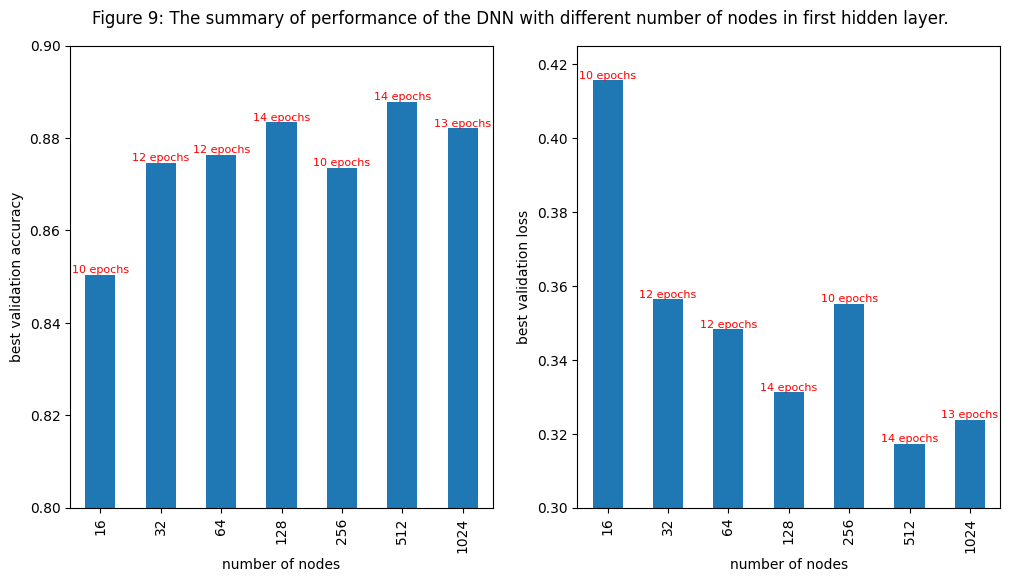

In [ ]:
from numpy.ma.core import argmax
#initialise the figure
fig,axs = plt.subplots(1,2,figsize=(12,6))
accuracy_list = []
loss_list = []
epoch_label_list = []
#loop through each training history and corresponding number of nodes in first layer
for i,train_h in enumerate(training_histories):
  #find the index of maximum accuracy achieved in training.
  max_index = argmax(train_h['val_accuracy'])
  #record the maximum validation accuracy achieved from training
  accuracy_list.append(train_h['val_accuracy'][max_index])
  #record the corresponding loss achieved from training
  loss_list.append(train_h['val_loss'][max_index])
  #record the number of epochs passed in training.
  epoch_label_list.append(len(train_h['val_accuracy']))
  #convert dictionary to dataframe
performance_df = pd.DataFrame({'number of nodes':nodes_range,
                                'best validation accuracy':accuracy_list,
                                'corresponding validation loss':loss_list,
                                'epoch labels':epoch_label_list})
# plot the accuracy values for validation per number of nodes in first hidden layer
p1 = performance_df.plot.bar(x='number of nodes',
                        y='best validation accuracy',
                        ax = axs[0],
                        ylim = (0.8,0.9),
                        legend = False,
                        ylabel = 'best validation accuracy')
axs[0].bar_label(p1.containers[0],
                 labels = ['%s epochs' % e for e in epoch_label_list], 
                 label_type = 'edge',
                 fontsize=8,
                 color = 'r')

  #plot the accuracy for validation on two different axis
p2 = performance_df.plot.bar(x='number of nodes',
                        y='corresponding validation loss',
                        ax = axs[1],
                        ylim = (0.3,0.425),
                        legend = False,
                        ylabel = 'best validation loss')
axs[1].bar_label(p2.containers[0],
                 labels = ['%s epochs' % e for e in epoch_label_list], 
                 label_type = 'edge',
                 fontsize=8,
                 color = 'r')
fig.suptitle("Figure 9: The summary of performance of the DNN with different number of nodes in first hidden layer.",y=0.94)

Figure 9 is a summary of the DNN model performance for different number of nodes in the first hidden layer, showing the best validation accuracy and loss achieved for the stated number of epochs under the early stopping condition.
***

4. From all of the above results, choose the best hyper-parameters and clearly state your reasons. Include a comment on how reliable and repeatable you think this choice is.

The Deep Neural Network that exhibits the best validation performance comprises of the following:
 -  two hidden layers of 512 and 64 nodes as determined by hyperparameter tuning on number of nodes of first hidden layer, achieving highest accuracy and smallest loss.
 -  Leaky ReLU activation in both layers with $\alpha = 0.0125$, as determined by random search cross-validation, which outperformed the sigmoid activation and was a slight improvement upon ReLU activation.
 - A learning rate of $\eta = 0.01$ leads to the best convergence of the model in less than 15 epochs and achieves the highest validation accuracies.

 Due to the stochasticity of the optimisation algorithm, Adam, the variability in the training can lead to a DNN with ReLU activation perform better than a DNN with Leaky ReLU activation, as shown in figure 6. The learning rate of 0.01 is consistently the better value as it delivers validation accuracies that are significantly higher than under other learning rates. However, there is little difference in the validation accuracies achieved by the DNN with 128, 512 and 1024 nodes in the first hidden layer, and so may not be consistently reproducible.  
 ***

# 6. Dropout

1. Using the best hyper-parameters from above, implement this model but include a dropout layer (with rate 0.4) between the last dense layer and the output layer.


In [ ]:
from keras.layers import Dropout
#build a neural network with LeakyRelu activation and dropout layer

### Set the best parameters of the model
best_layers = [512,64]
dropout_rate = 0.4
#define a dictionary of parameters for the keras model
best_params_dropout = {'kerasclassifier__layers' : best_layers,
                       'kerasclassifier__alpha': best_alpha,
                       'kerasclassifier__lrate' : best_lrate,
                       'kerasclassifier__dropout_rate' : dropout_rate}

# Function to create model, required for KerasClassifier
def LeakyReLUmodel_dropout_build_fn(layers: list[int],alpha: float,lrate: float,dropout_rate: float):
  """
  defines the dense neural network model using Leaky ReLU activation function with keras.
  Arguments:
  layers = The number of neurons in the hidden layers defined as list.
  alpha = The parameter for the Leaky ReLU activation function gives gradient for linear component when x<0.
  lrate = learning rate for optimiser.
  dropout_rate = The frequency at which the dropout regularisation sets input units to 0 and scale up remian nodes by 1/(1-rate)
  """ 
  #kera starts with a blank state
  clear_session()
  # develop a sequential model.
  model = Sequential()
  # flatten the input images as the product of the pixels.
  model.add(Input(shape = (28*28,)))
  # Create model sequentially
  # add the first hidden layer
  model.add(Dense(layers[0],kernel_initializer = HeNormal(seed = 1)))
  # now add a ReLU activation explicitly
  model.add(LeakyReLU(alpha=alpha))
  # add the second hidden layer
  model.add(Dense(layers[1],kernel_initializer =  HeNormal(seed = 1)))
  # now add a ReLU activation explicitly
  model.add(LeakyReLU(alpha=alpha))
  # include a dropout layer with dropout_rate
  model.add(Dropout(dropout_rate))
  #set the last layer as the output layer with 10 nodes, one for each class.
  model.add(Dense(10,activation = 'softmax'))
  #initialise optimiser with learning rate
  opt = Adam(learning_rate = lrate)
  # Compile model
  model.compile(loss = 'sparse_categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
  return model

# Sklearn wrapper of the keras model
best_sklearn_model_dropout = KerasClassifier(model = LeakyReLUmodel_dropout_build_fn,
                                             layers = [128,64],
                                             alpha = 0.01,
                                             lrate = 0.001,
                                             dropout_rate=0.4,
                                             callbacks = early_stopping_cb)#employing early stopping callback,
                                                                           # routes params to fit
# model pipeline
best_estimator_dropout = make_pipeline(preproc,best_sklearn_model_dropout)
# set the parameters of the model to the defined values.
best_estimator_dropout.set_params(**best_params_dropout)
# Summary of the Keras model.
LeakyReLUmodel_dropout_build_fn(best_layers,alpha,best_lrate,dropout_rate).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 435,402
Trainable params: 435,402
Non-trai

2. Train this and compare the result with the one from the equivalent network without dropout and decide whether the network performs better with dropout or not. Show learning curves and a brief summary of the results and your decision.

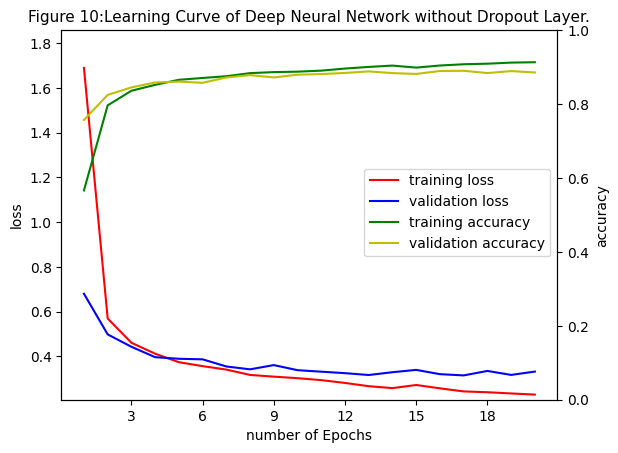

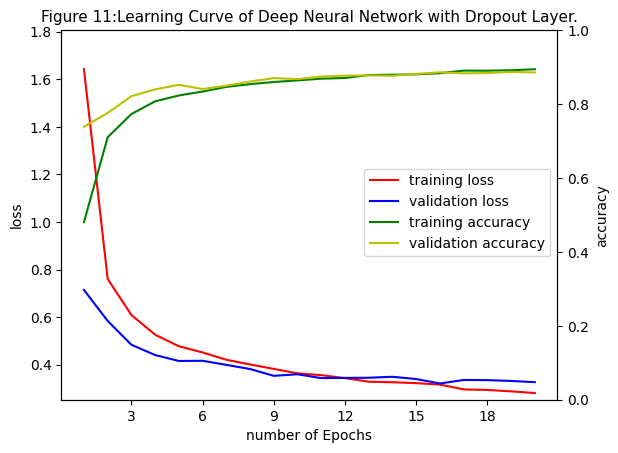

<Figure size 640x480 with 0 Axes>

In [ ]:
### DNN with best parameters and without dropout layer
# Sklearn wrapper of the keras model
sklearn_model_best = KerasClassifier(model = LeakyReLUmodel_build_fn,
                                    layers = best_layers, 
                                    alpha = best_alpha,
                                    lrate = best_lrate,
                                    callbacks = early_stopping_cb) # employing early stopping callback, routes params to fit
# model pipeline
estimator_best = make_pipeline(preproc,sklearn_model_best)
# training the model with the given number of epoc hand batch size and saving the training history,
history_best = estimator_best.fit(X_train, 
                                y_train,
                                kerasclassifier__epochs = epochs_n,
                                kerasclassifier__batch_size=2000,
                                kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                kerasclassifier__verbose = 0)   

#record the history of the training process as a dictionary
history_best_record_dict = history_best.named_steps['kerasclassifier'].history_

### DNN with best parameters and with dropout layer
# training the model with the given number of epocs hand batch size and saving the training history,
history_best_dropout = best_estimator_dropout.fit(X_train, 
                                                  y_train,
                                                  kerasclassifier__epochs = epochs_n,
                                                  kerasclassifier__batch_size=2000,
                                                  kerasclassifier__validation_data=(X_validate_processed, y_validate),
                                                  kerasclassifier__verbose = 0) 
#record the history of the training process as a dictionary
history_best_droupout_record_dict = history_best_dropout.named_steps['kerasclassifier'].history_

model_training_histories = [history_best_record_dict,history_best_droupout_record_dict]
#loop through the two models
for i,train_h in enumerate(model_training_histories):
   # initialise the axis
  ax = plt.subplot()
  word = "without" if i == 0 else "with"
  title = f"Figure {str(10+i)}:Learning Curve of Deep Neural Network {word} Dropout Layer."
  # produce the learning curve graph
  learning_curve(train_h,title,ax)
plt.tight_layout()

The Deep Neural Network with the Dropout layer as seen in figure 11, achieves a more stable validation loss curve, is lower overall and presents a reduced gap between training and validation learning curves. The dropout regularisation effectively prevents overfitting and leads to a validation accuracy very close to training accuracy, compared to the DNN without the Dropout layer. The learning curve of the DNN without dropout in figure 10 exhibits a greater difference between training and validation scores, resembling slight over fitting.

In [ ]:
for i, train_h in enumerate(model_training_histories):
  max_index1 = argmax(train_h['val_accuracy'])
  model_accuracy = train_h['val_accuracy'][max_index1]
  model_validation = train_h['val_loss'][max_index1]
  word = "without" if i == 0 else "with"
  print(f"DNN model {word} Dropout layer gives validation accuracy of {model_accuracy:0.3f}\
   and validation loss of {model_validation:0.3f}")

DNN model without Dropout layer gives validation accuracy of 0.890   and validation loss of 0.315
DNN model with Dropout layer gives validation accuracy of 0.887   and validation loss of 0.332


The validation scores of the model with the dropout layer are slightly reduced compared to the DNN without the dropout layer, though are a better estimate of the generalisation error.

The model with the Dropout layer is chosen as the best model.

# 7. Final evaluation

1. Evaluate final performance using the best network (chosen from all the options you have explored above)

In [ ]:
### evaluate the best model
results = best_estimator_dropout.score(X_test, y_test)
print(f'Test accuracy is: {results*100: 0.2f}%')

313/313 [==============================] - 1s 4ms/step
Test accuracy is:  87.71%


2. Calculate the confusion matrix from these results and show the matrix graphically

313/313 [==============================] - 2s 6ms/step


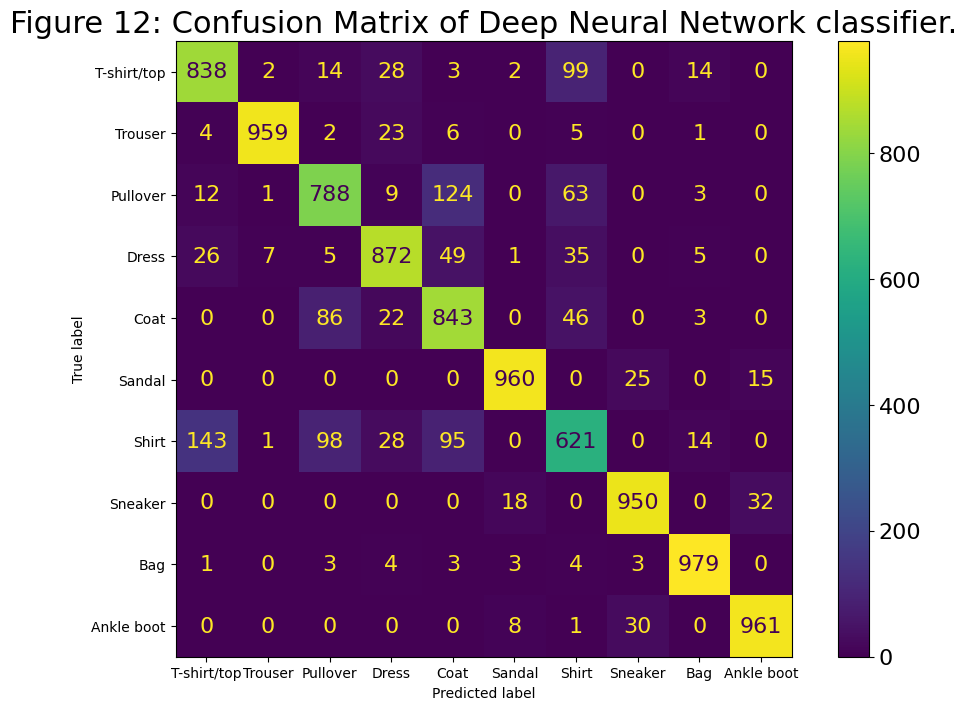

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# predictions of classes using the test data set
y_pred = best_estimator_dropout.predict(X_test)
# Evaluate the predictions by analysing the confusion matrix.
cm = confusion_matrix(y_test,y_pred)
#Initialise the figure of the Confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))    
ax.grid(False)
#Set title and font size of the Confusion Matrix
plt.title("Figure 12: Confusion Matrix of Deep Neural Network classifier.",{'fontsize': 22})
plt.rc('font', **{'size':16})
#Display confusion matrix from the predictions on the testing data set
ConfusionMatrixDisplay.from_predictions(y_test,y_pred,display_labels =class_names,ax=ax )

3. Identify which class is most often incorrectly classified, explaining your reasoning

The class that is most often incorrectly classified is the **Shirt** . It is falsely predicted on $1000 - 621 = 379$ occasions, which is 37.9% false prediction rate. False predictions of **Shirt** are **T-shirt/top** at 14.3% and then **Pullover** at 9.8% rates.

4. If the correct class is number 6 (shirt), which is the most likely error that your network will make (explain your reasoning).

If the correct class is **shirt**, the model will most likely misclassify as **T-shirt/top**. Out of all the errors for **shirt**, which are 379, the **T-shirt/top** accounts for 143 of them, a percentage of $143 ÷ 379 𝚇 100 = 37.7$%